<div align=center>

<p></p>
<p></p>
<font size=5>
In the Name of God
<font/>
<p></p>
 <br/>
    <br/>
<font color=#4d7db8>
Sharif University of Technology - Department of Electrical Engineering
</font>
<p></p>
<font color=#4d7db8>
Introduction To Machine Learning - Dr. Sajjad Amini
</font>
<br/>
<br/>
Spring Semester 1401-02

<div/>

<hr/>
		<div align=center>
		    <font color=red size=6>
			    <br />
        Project - 3rd Phase
        <br />
        Image Colorization using Autoencoder
			</font>
    <br/>
<font size=4>
			<br/><br/>
Due on Tir 10th
                <br/><b>
              Cheating is Strongly Prohibited
                </b><br/><br/>
                <font color=green>
Should you have any questions concerning the project, please feel free to ask via Telegram.
     </font>
</font>
                <br/>
    </div>

# Personal Info
<hr/>
    <div class="column" align=center>
    <font size=4>
        <div class="column">
        <br />
            student_number = 98102002
            <br />
            Name = Shaghayegh    
            <br />
            Last_Name = Ataei
        </div>
        <div class="column">
        <br />
            student_number = 99101076
            <br />
            Name = Naghmeh   
            <br />
            Last_Name = Adibi
        </div>
    </font>
    </div>


1. Download the "landscape image colorization" dataset and slice it to `train_set`, `validation_set` and `test_set`.
2. Design and train an AutoEncoder using `PyTorch` (not `TensorFlow`) on the dataset to colorize grayscale images
3. plot learning curve and visualize grayscale images of test set, their corresponding color images and their colorized versions side by side.

# Import Necessary Libraries

In [ ]:
import os
import torch
import numpy as np
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from skimage.color import rgb2lab, lab2rgb
import matplotlib.pyplot as plt

# Load Dataset and Prepare It

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#the dimension of each image in color / gray data:
sample_img = read_image('/content/0.jpg')
sample_img.shape

torch.Size([1, 150, 150])

Since we have labels for all of the images (namely training, validation and test set), we dont need to separate data preparation class for these sets.

In [ ]:
class Data_Prep(Dataset):
    def __init__(self, slices, transform=None):

        self.transform = transform
        self.slices = slices
        self.img = '/content/drive/MyDrive/gray/'
        self.label = '/content/drive/MyDrive/color/'

    def __len__(self):
        return len(self.slices)

    def __getitem__(self, idx):
        image = read_image(self.img + str(idx)+'.jpg')
        #making tensor 2D:
        image = image.unsqueeze(0)
        image = F.interpolate(image,(160,160))
        image = image.squeeze(0)
        image = image.permute(1,2,0)
        image = image.repeat(1,1,3)
        image = image.permute(2,0,1)

        label = read_image(self.label + str(idx)+'.jpg')
        label = label.unsqueeze(0)
        label = F.interpolate(label,(160,160))
        label = label.squeeze(0)
        label = label.permute(1,2,0)
        label = label.permute(2,0,1)
        image = torch.tensor(rgb2lab(image.permute(1,2,0)/255))
        label = torch.tensor(rgb2lab(label.permute(1,2,0)/255))

        image = (image + torch.tensor([0, 128, 128])) / torch.tensor([100, 255, 255])
        label = (label + torch.tensor([0, 128, 128])) / torch.tensor([100, 255, 255])

        image = image.permute(2,0,1)
        label = label.permute(2,0,1)
        #Using L dimension of Lab image:
        image = image[:1,:,:]
        #prediction is based on a & b dimensions of Lab image:
        label = label[1:,:,:]

        return image, label

In [ ]:
#setting the slices for train and validation (80% train, 20% validation):
n = int(round(7129*0.8))
train_slice = np.arange(0, n, 1)
val_slice = np.arange(n, 7129, 1)

In [ ]:
train_set = Data_Prep(slices = train_slice)
validation_set = Data_Prep(slices = val_slice)

train_dataloader = DataLoader(train_set,batch_size=20,shuffle=True)
val_dataloader   = DataLoader(validation_set,batch_size=20,shuffle=True)

# Define Your Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        #Encoder:
        self.conv1 = nn.Conv2d(1, 64, 3,stride=1,padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, stride=2,padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3,stride=2,padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3,stride=2,padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        #Decoder:
        self.t_conv1 = nn.ConvTranspose2d(256, 128, 3, stride=2,padding=1,output_padding=1)
        self.t_conv2 = nn.ConvTranspose2d(256, 64, 3, stride=2,padding=1,output_padding=1)
        self.t_conv3 = nn.ConvTranspose2d(128, 128, 3, stride=2,padding=1,output_padding=1)
        self.t_conv4 = nn.ConvTranspose2d(192, 15, 3, stride=1,padding=1)
        self.dropout = nn.Dropout(0.2)
        self.converge = nn.Conv2d(16,2,3,stride=1,padding=1)

    def forward(self, x):
        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv2(x1))
        x3 = F.relu(self.conv3(x2))
        x4 = F.relu(self.conv4(x3))
        xu = F.relu(self.t_conv1(x4))
        xu = torch.cat((xu, x3), dim=1)
        xu = self.dropout(xu)
        xu = F.relu(self.t_conv2(xd))
        xu = torch.cat((xu, x2), dim=1)
        xu = self.dropout(xu)
        xu = F.relu(self.t_conv3(xu))
        xu = torch.cat((xu, x1), dim=1)
        xu = self.dropout(xu)
        xu = F.relu(self.t_conv4(xu))
        xu = torch.cat((xu, x), dim=1)
        y  = F.relu(self.converge(xu))
        return y

model = AutoEncoder()
model.to('cuda')

AutoEncoder(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (t_conv2): ConvTranspose2d(256, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (t_conv3): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (t_conv4): ConvTranspose2d(192, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout(p=0.2, inplace=False)
  (converge): Conv2d(16, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

# Fit The Model

Also Define optimizer, Criterion and other parameters

In [ ]:
LOSS = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
from tqdm import tqdm
epochs = 20
train_lossHistory = []
val_lossHistory = []

for epoch in range(epochs):
    train_loss = 0
    for data in tqdm(train_dataloader):
        img, label = data
        #changing the device of tensors to match with the model:
        img = img.float().to('cuda')
        label = label.float().to('cuda')
        optimizer.zero_grad()
        colored = model(img)
        loss = LOSS(colored, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*img.size(0)

    train_lossHistory.append(train_loss/len(train_dataloader))
    print('TRAINING : Epoch No. ' + str(epoch) + ' Loss : ', train_loss)

    # Entering the validation set:
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to('cuda'), labels.to('cuda')
            output = model(images)
            loss = LOSS(output, labels)
            val_loss += loss.item()*images.size(0)

    val_lossHistory.append(val_loss/len(val_dataloader))
    print('VALIDATION : Epoch No. ' + str(epoch) + ' Loss : ', val_loss)


100%|██████████| 286/286 [01:53<00:00,  2.52it/s]


TRAINING : Epoch No. 0 Loss :  12.954597176983953
VALIDATION : Epoch No. 0 Loss :  2.9146259820554405


100%|██████████| 286/286 [01:54<00:00,  2.51it/s]


TRAINING : Epoch No. 1 Loss :  12.706743594957516
VALIDATION : Epoch No. 1 Loss :  3.37260062340647


100%|██████████| 286/286 [01:53<00:00,  2.51it/s]


TRAINING : Epoch No. 2 Loss :  12.781068624230102
VALIDATION : Epoch No. 2 Loss :  2.9614129760302603


100%|██████████| 286/286 [01:52<00:00,  2.54it/s]


TRAINING : Epoch No. 3 Loss :  12.72958116652444
VALIDATION : Epoch No. 3 Loss :  3.0527786849997938


100%|██████████| 286/286 [01:51<00:00,  2.56it/s]


TRAINING : Epoch No. 4 Loss :  12.488641576550435
VALIDATION : Epoch No. 4 Loss :  3.0011329350527376


100%|██████████| 286/286 [01:51<00:00,  2.56it/s]


TRAINING : Epoch No. 5 Loss :  12.369285553111695
VALIDATION : Epoch No. 5 Loss :  3.0583200664259493


100%|██████████| 286/286 [01:50<00:00,  2.59it/s]


TRAINING : Epoch No. 6 Loss :  12.470499958959408
VALIDATION : Epoch No. 6 Loss :  2.956979921553284


100%|██████████| 286/286 [01:51<00:00,  2.57it/s]


TRAINING : Epoch No. 7 Loss :  12.326616161270067
VALIDATION : Epoch No. 7 Loss :  3.092760801082477


100%|██████████| 286/286 [01:50<00:00,  2.59it/s]


TRAINING : Epoch No. 8 Loss :  12.362348180497065
VALIDATION : Epoch No. 8 Loss :  3.073070999002084


100%|██████████| 286/286 [01:50<00:00,  2.58it/s]


TRAINING : Epoch No. 9 Loss :  12.31010810774751
VALIDATION : Epoch No. 9 Loss :  2.8155796106439084


100%|██████████| 286/286 [01:50<00:00,  2.59it/s]


TRAINING : Epoch No. 10 Loss :  12.01842642459087
VALIDATION : Epoch No. 10 Loss :  3.036344129126519


100%|██████████| 286/286 [01:49<00:00,  2.61it/s]


TRAINING : Epoch No. 11 Loss :  12.009910172433592
VALIDATION : Epoch No. 11 Loss :  3.153541414067149


100%|██████████| 286/286 [01:50<00:00,  2.59it/s]


TRAINING : Epoch No. 12 Loss :  12.038002901128493
VALIDATION : Epoch No. 12 Loss :  2.785173370037228


100%|██████████| 286/286 [01:50<00:00,  2.60it/s]


TRAINING : Epoch No. 13 Loss :  11.807929121947382
VALIDATION : Epoch No. 13 Loss :  2.7704457538202405


100%|██████████| 286/286 [01:51<00:00,  2.57it/s]


TRAINING : Epoch No. 14 Loss :  11.79788075457327
VALIDATION : Epoch No. 14 Loss :  2.6832348552998155


100%|██████████| 286/286 [01:49<00:00,  2.61it/s]


TRAINING : Epoch No. 15 Loss :  11.673554612323642
VALIDATION : Epoch No. 15 Loss :  2.756621142849326


100%|██████████| 286/286 [01:50<00:00,  2.60it/s]


TRAINING : Epoch No. 16 Loss :  11.692148595815524
VALIDATION : Epoch No. 16 Loss :  2.7960455550346524


100%|██████████| 286/286 [01:51<00:00,  2.57it/s]


TRAINING : Epoch No. 17 Loss :  11.747959279455245
VALIDATION : Epoch No. 17 Loss :  2.6340887867845595


100%|██████████| 286/286 [01:51<00:00,  2.57it/s]


TRAINING : Epoch No. 18 Loss :  11.383108065812849
VALIDATION : Epoch No. 18 Loss :  2.90109976939857


100%|██████████| 286/286 [01:52<00:00,  2.55it/s]


TRAINING : Epoch No. 19 Loss :  11.474438190460205
VALIDATION : Epoch No. 19 Loss :  2.6017566996160895


# Plot The Results

ploting learning curves:

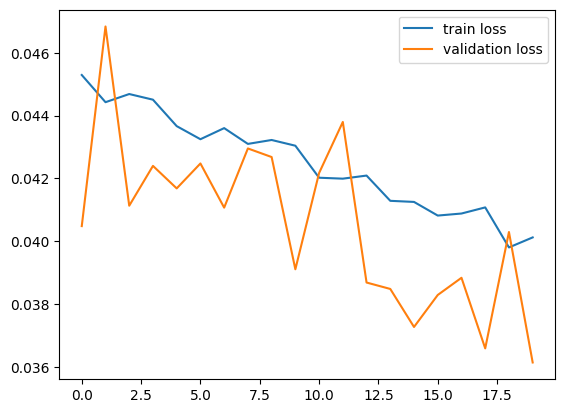

In [ ]:
plt.plot(train_lossHistory, label = 'train loss')
plt.plot(val_lossHistory, label = 'validation loss')
plt.legend()
plt.show()

ploting the results:

Here we plot 3 set of 5 images which had good results:

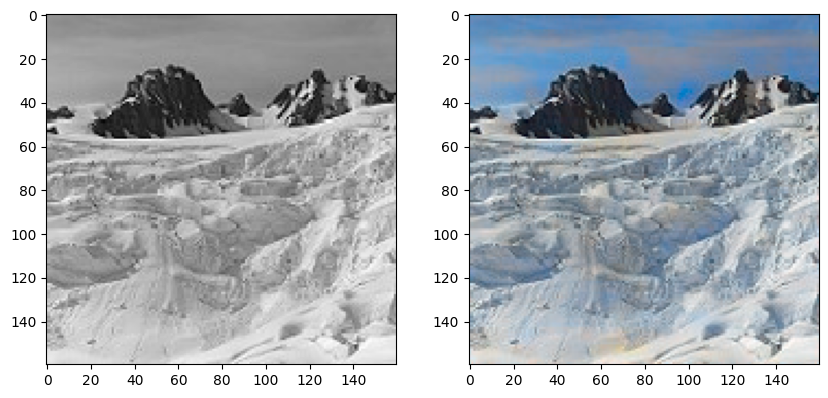

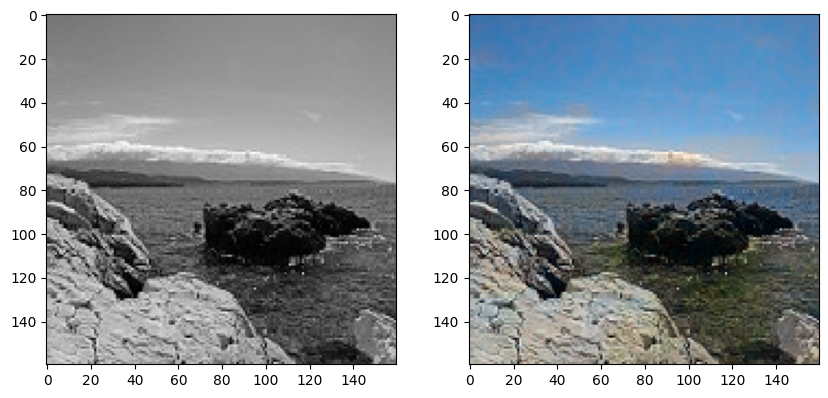

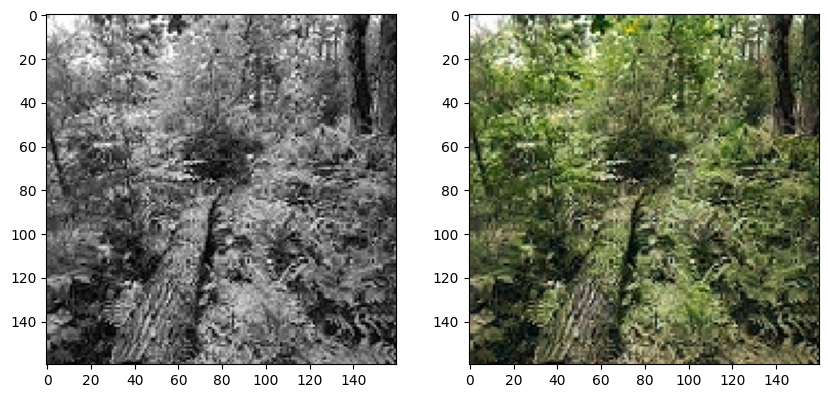

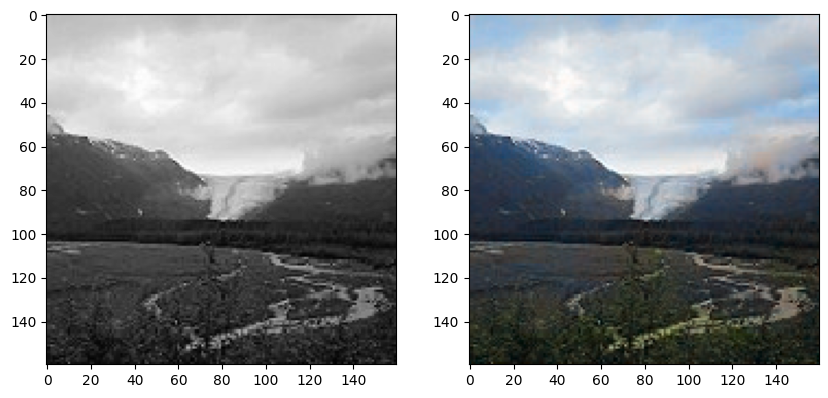

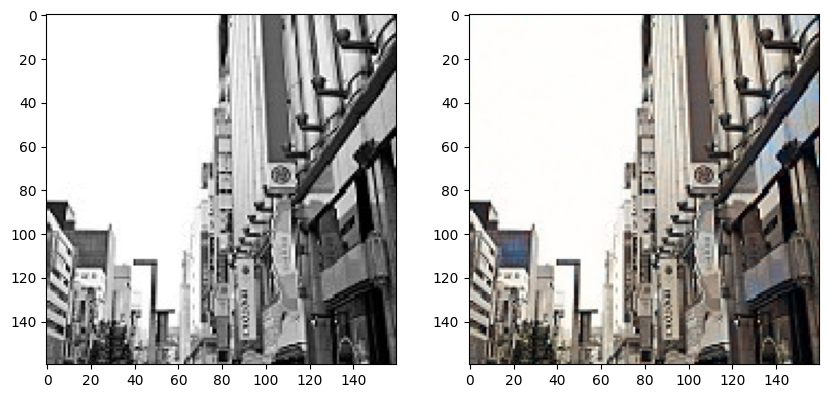

In [ ]:
for i in range(5):
    img,label = next(iter(val_dataloader))
    pred = model.forward(img[0].float().cuda().view(1,1,160,160))

    #using prediction on a & b dimensios (pred), concatinating with L dimension (img[0]) to rebuild RGB image:
    lab_pred = torch.cat((img[0].view(1,160,160),pred[0].cpu()),dim=0).permute(1,2,0)
    lab_pred = lab_pred * torch.tensor([100,255,255]) - torch.tensor([0,128,128])
    rgb_pred = lab2rgb(lab_pred.detach().numpy())
    fig = plt.figure(figsize=(10,10))
    plt.subplot(221)
    plt.imshow(img[0].permute(1,2,0),cmap='gray')
    plt.subplot(222)
    plt.imshow(rgb_pred)
    plt.show()

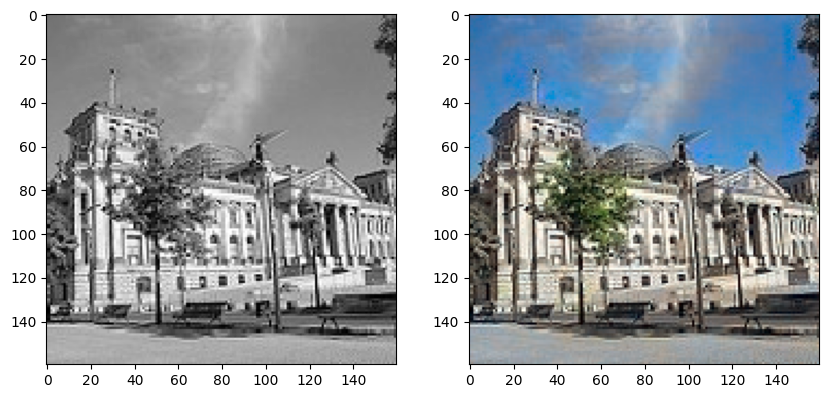

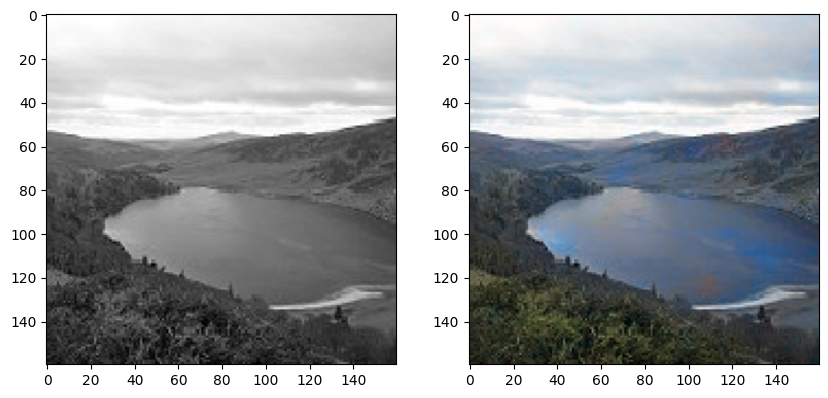

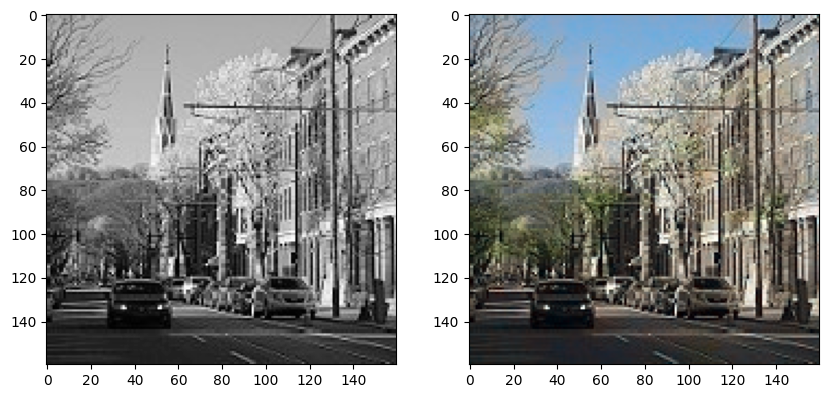

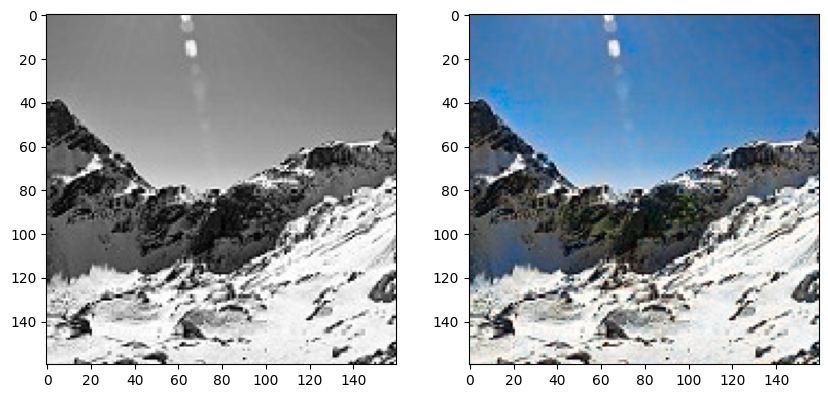

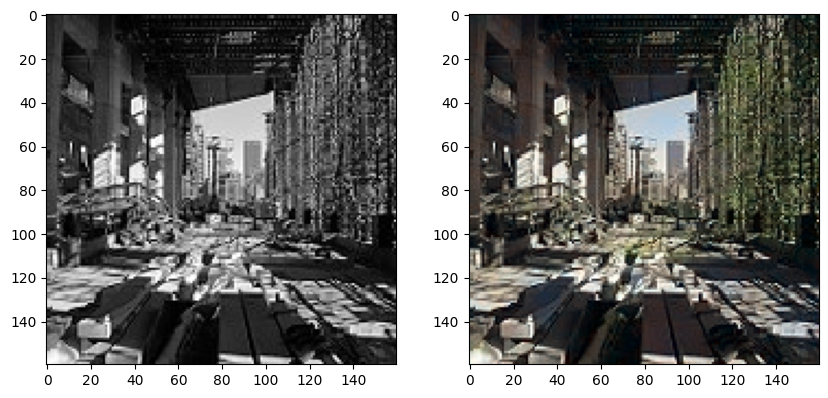

In [ ]:
for i in range(5):
    img,label = next(iter(val_dataloader))
    pred = model.forward(img[0].float().cuda().view(1,1,160,160))

    #using prediction on a & b dimensios (pred), concatinating with L dimension (img[0]) to rebuild RGB image:
    lab_pred = torch.cat((img[0].view(1,160,160),pred[0].cpu()),dim=0).permute(1,2,0)
    lab_pred = lab_pred * torch.tensor([100,255,255]) - torch.tensor([0,128,128])
    rgb_pred = lab2rgb(lab_pred.detach().numpy())
    fig = plt.figure(figsize=(10,10))
    plt.subplot(221)
    plt.imshow(img[0].permute(1,2,0),cmap='gray')
    plt.subplot(222)
    plt.imshow(rgb_pred)
    plt.show()

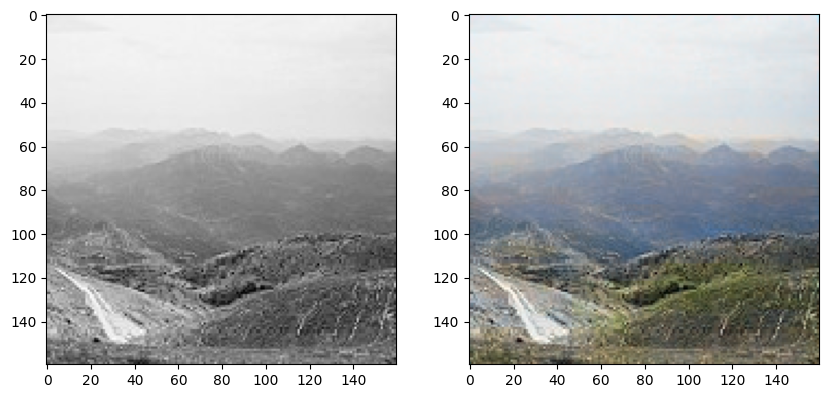

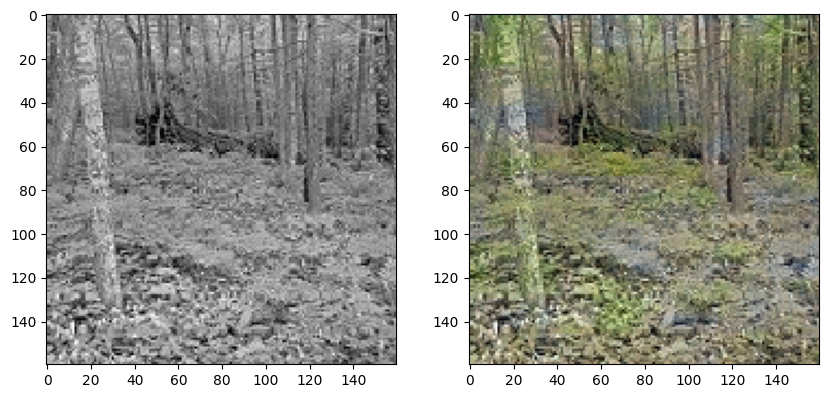

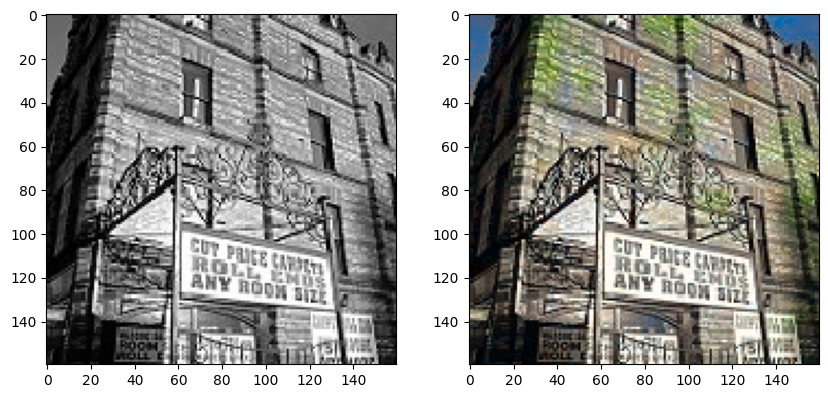

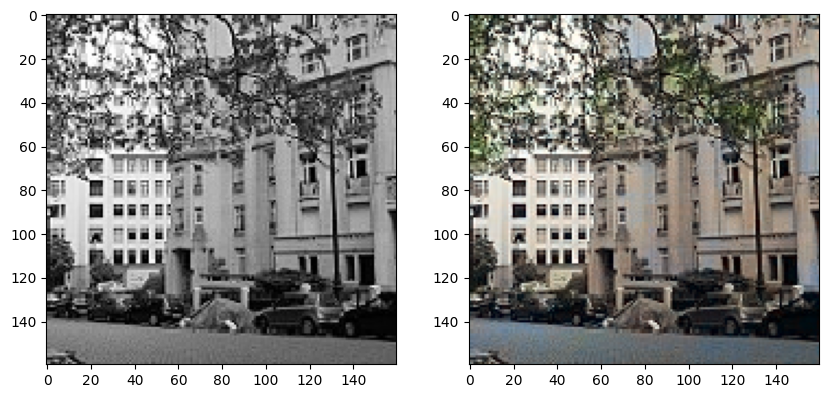

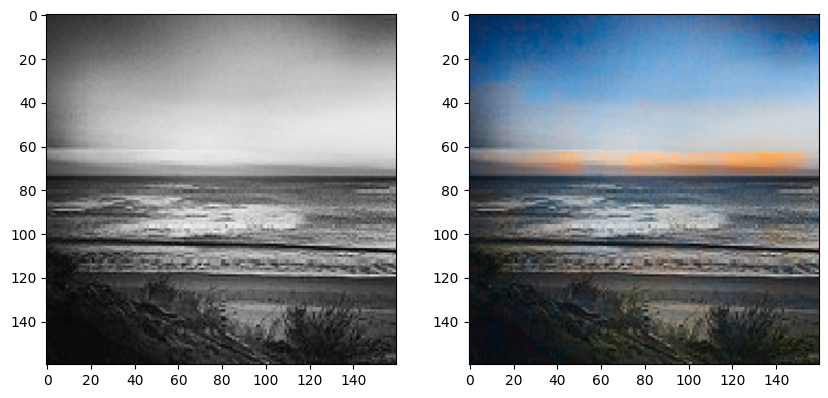

In [ ]:
for i in range(5):
    img,label = next(iter(val_dataloader))
    pred = model.forward(img[0].float().cuda().view(1,1,160,160))

    #using prediction on a & b dimensios (pred), concatinating with L dimension (img[0]) to rebuild RGB image:
    lab_pred = torch.cat((img[0].view(1,160,160),pred[0].cpu()),dim=0).permute(1,2,0)
    lab_pred = lab_pred * torch.tensor([100,255,255]) - torch.tensor([0,128,128])
    rgb_pred = lab2rgb(lab_pred.detach().numpy())
    fig = plt.figure(figsize=(10,10))
    plt.subplot(221)
    plt.imshow(img[0].permute(1,2,0),cmap='gray')
    plt.subplot(222)
    plt.imshow(rgb_pred)
    plt.show()